In [2]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [3]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [4]:
def plot_latent(image, shape=[10, 10]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [5]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [6]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        layer1_val = hidden1.eval(feed_dict={X:X_test})
        layer2_val = hidden2.eval(feed_dict={X:X_test})
        layer3_val = hidden3.eval(feed_dict={X:X_test})
        latent_val = hidden4.eval(feed_dict={X:X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
        #plot_layer1(layer1_val[digit_index])
        #plot_layer2(layer2_val[digit_index])
        #plot_layer3(layer3_val[digit_index])
        plot_latent(latent_val[digit_index])
    return latent_val

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [8]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [9]:
hidden_output1, W1, b1, W8, b8 = train_autoencoder(mnist.train.images, n_neurons=400, n_epochs=10, batch_size=150)
hidden_output2, W2, b2, W7, b7 = train_autoencoder(hidden_output1, n_neurons=225, n_epochs=10, batch_size=150)
hidden_output3, W3, b3, W6, b6 = train_autoencoder(hidden_output2, n_neurons=100, n_epochs=10, batch_size=150)
_, W4, b4, W5, b5 = train_autoencoder(hidden_output3, n_neurons=100, n_epochs=10, batch_size=150)

0 Train MSE: 0.0181435
1 Train MSE: 0.0175545
2 Train MSE: 0.0193814
3 Train MSE: 0.0192293
4 Train MSE: 0.0188824
5 Train MSE: 0.0188667
6 Train MSE: 0.0193256
7 Train MSE: 0.0192598
8 Train MSE: 0.0203289
9 Train MSE: 0.01988
0 Train MSE: 0.00415801
1 Train MSE: 0.00455566
2 Train MSE: 0.00452734
3 Train MSE: 0.00468816
4 Train MSE: 0.00448234
5 Train MSE: 0.00458103
6 Train MSE: 0.00456942
7 Train MSE: 0.0047599
8 Train MSE: 0.00440206
9 Train MSE: 0.00424709
0 Train MSE: 0.00219364
1 Train MSE: 0.00237149
2 Train MSE: 0.00240938
3 Train MSE: 0.00223794
4 Train MSE: 0.00242104
5 Train MSE: 0.00232344
6 Train MSE: 0.00258758
79% Train MSE: 0.0024302
8 Train MSE: 0.00235858
9 Train MSE: 0.00236761
0 Train MSE: 0.00121433
1 Train MSE: 0.00124752
2 Train MSE: 0.0014579
3 Train MSE: 0.001515
4 Train MSE: 0.00163132
5 Train MSE: 0.0014587
6 Train MSE: 0.00155305
7 Train MSE: 0.00171634
8 Train MSE: 0.00151823
9 Train MSE: 0.00162876


In [10]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
hidden4 = tf.nn.elu(tf.matmul(hidden3, W4) + b4)
hidden5 = tf.nn.elu(tf.matmul(hidden4, W5) + b5)
hidden6 = tf.nn.elu(tf.matmul(hidden5, W6) + b6)
hidden7 = tf.nn.elu(tf.matmul(hidden6, W7) + b7)
outputs = tf.matmul(hidden7, W8) + b8

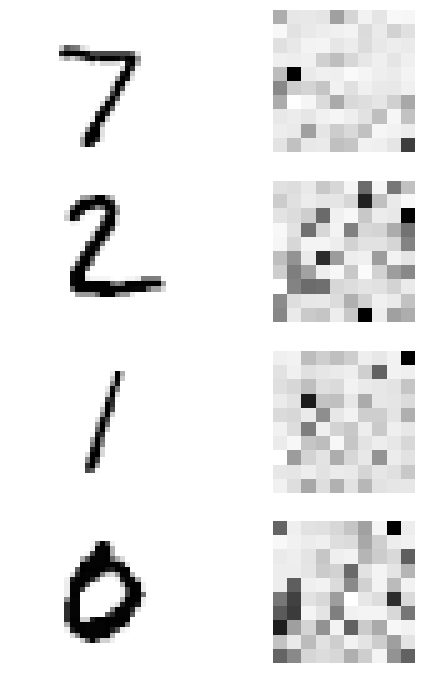

In [11]:
latent =show_reconstructed_digits(X, outputs, n_test_digits = 4)

In [12]:
mnist.train.images.shape

(55000, 784)

In [13]:
sp500_data = np.genfromtxt('data/data_wt/sp500_wt.csv', delimiter=',', dtype=float, names=True)
print(sp500_data.dtype.names) # print names of columns

('Ntime', 'time', 'Close_Price', 'Open_Price', 'High_Price', 'Low_Price', 'Volume', 'MACD', 'CCI', 'ATR', 'BOLL', 'EMA20', 'MA10', 'MTM6', 'MA5', 'MTM12', 'ROC', 'SMI', 'WVAD', 'US_Dollar_Index', 'Federal_Fund_Rate')


In [15]:
import pandas as pd
pd.DataFrame(sp500_data)

,Ntime,time,Close_Price,Open_Price,High_Price,Low_Price,Volume,MACD,CCI,ATR,...,EMA20,MA10,MTM6,MA5,MTM12,ROC,SMI,WVAD,US_Dollar_Index,Federal_Fund_Rate
0,20080701.0,733590.0,1265.4100,1272.0925,1280.7275,1253.7200,490884.75,-28.0042,-117.4403,27.0075,...,1318.4615,1296.5683,-42.7500,1277.2860,-86.8175,-6.5078,-0.0479,-4.971306e+07,72.4425,1.9925
1,20080702.0,733591.0,1265.4100,1272.0925,1280.7275,1253.7200,490884.75,-28.0042,-117.4403,27.0075,...,1318.4615,1296.5683,-42.7500,1277.2860,-86.8175,-6.5078,-0.0479,-4.971306e+07,72.4425,1.9925
2,20080703.0,733592.0,1265.4100,1272.0925,1280.7275,1253.7200,490884.75,-28.0042,-117.4403,27.0075,...,1318.4615,1296.5683,-42.7500,1277.2860,-86.8175,-6.5078,-0.0479,-4.971306e+07,72.4425,1.9925
3,20080707.0,733596.0,1265.4100,1272.0925,1280.7275,1253.7200,490884.75,-28.0042,-117.4403,27.0075,...,1318.4615,1296.5683,-42.7500,1277.2860,-86.8175,-6.5078,-0.0479,-4.971306e+07,72.4425,1.9925
4,20080708.0,733597.0,1252.8175,1254.7825,1266.6125,1237.3800,594943.50,-30.3207,-98.8497,29.2325,...,1298.2072,1271.5725,-19.5150,1259.0515,-70.4450,-4.9478,-0.0357,-4.862382e+07,72.4875,1.9850
5,20080709.0,733598.0,1252.8175,1254.7825,1266.6125,1237.3800,594943.50,-30.3207,-98.8497,29.2325,...,1298.2072,1271.5725,-19.5150,1259.0515,-70.4450,-4.9478,-0.0357,-4.862382e+07,72.4875,1.9850
6,20080710.0,733599.0,1252.8175,1254.7825,1266.6125,1237.3800,594943.50,-30.3207,-98.8497,29.2325,...,1298.2072,1271.5725,-19.5150,1259.0515,-70.4450,-4.9478,-0.0357,-4.862382e+07,72.4875,1.9850
7,20080711.0,733600.0,1252.8175,1254.7825,1266.6125,1237.3800,594943.50,-30.3207,-98.8497,29.2325,...,1298.2072,1271.5725,-19.5150,1259.0515,-70.4450,-4.9478,-0.0357,-4.862382e+07,72.4875,1.9850
8,20080714.0,733603.0,1237.2225,1232.3500,1248.9200,1219.5825,672558.50,-31.9101,-94.7610,29.3375,...,1277.6894,1251.2318,-21.1775,1239.5090,-53.6525,-3.4649,-0.0274,-4.321184e+07,71.9425,2.0500
9,20080715.0,733604.0,1237.2225,1232.3500,1248.9200,1219.5825,672558.50,-31.9101,-94.7610,29.3375,...,1277.6894,1251.2318,-21.1775,1239.5090,-53.6525,-3.4649,-0.0274,-4.321184e+07,71.9425,2.0500
